# Build a varitaional quantum circuit in Qiskit
as opposed to the pre-built algorithms like VQE

In [8]:
import numpy as np
from scipy.optimize import minimize
import qiskit
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from matplotlib import pyplot as plt

In [2]:
from qiskit_machine_learning.neural_networks import CircuitQNN

In [3]:
L = 6
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters

In [9]:
def prepare_circuit(thetas):
    qreg = qiskit.QuantumRegister(L, 'q')
    creg = qiskit.ClassicalRegister(2, 'c')
    circ = qiskit.QuantumCircuit(qreg, creg)
    for i,t in enumerate(thetas[:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
    circ.ry(thetas[2*L], 4)
    circ.ry(thetas[2*L+1], 5)
    circ.measure(qreg[4], creg[0])
    circ.measure(qreg[5], creg[1])
    return circ

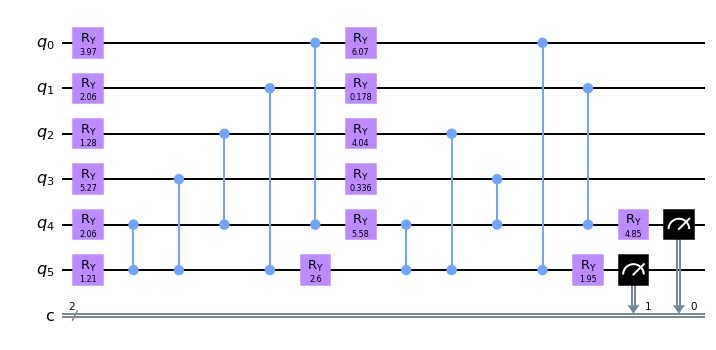

In [36]:
circ = prepare_circuit(thetas)
circ.draw('mpl') # trash qubits are at the bottom

In [21]:
num_trash = 2
entangler_map2 = [(5,4),(5,2),(4,3),(5,0),(4,1)]
entangler_map1 = [(5,4),(5,3),(5,1),(4,2),(4,0)]

[qiskit.circuit.library.TwoLocal(..) documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html?highlight=twolocal#qiskit.circuit.library.TwoLocal)

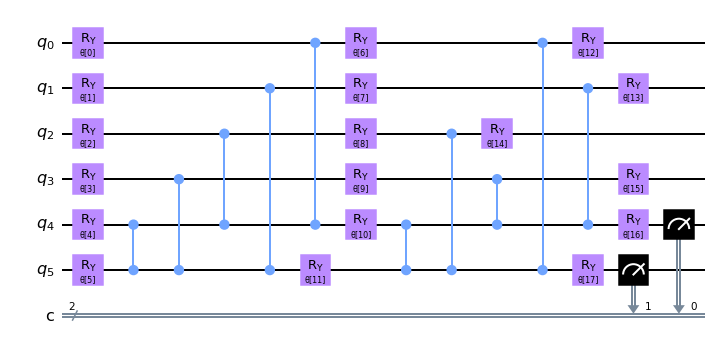

In [48]:
# Use Qiskit layer generator thingy because now it has everything it needs to get a gradient!
# Note that it has redundant Ry rotations at the end on the compression qubits, didnt find a clever way how to get rid of them, but this shouldnt change too much

# variational ansatz sub-circuit
ansatz = qiskit.circuit.library.TwoLocal(L,"ry","cz",[entangler_map1,entangler_map2],reps=2, insert_barriers=False)

# measurement circuit
qreg = qiskit.QuantumRegister(L, 'q')
creg = qiskit.ClassicalRegister(2, 'c')
measurement_circ = qiskit.QuantumCircuit(qreg, creg)
measurement_circ.measure(qreg[4], creg[0])
measurement_circ.measure(qreg[5], creg[1])
circ2 = ansatz + measurement_circ
circ2.decompose()
#print(circ2)
#measurement_circ.draw("mpl")
circ2.draw("mpl")

In [52]:
circ.parameters

ParameterView([])

In [51]:
circ2.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17])])

following [this tutorial on quantum neural networks](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html)

In [54]:
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=10)
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [57]:
qnn4 = CircuitQNN(circ2, [], circ2.parameters, sparse=False, quantum_instance=qi_qasm)

In [58]:
input4 = np.random.rand(qnn4.num_inputs)
weights4 = np.random.rand(qnn4.num_weights)

In [59]:
qnn4.forward(input4, weights4)

array([[0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [60]:
qnn4.backward(input4, weights4)

(array([], shape=(1, 64, 0), dtype=float64),
 array([[[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  , -0.05, ...,  0.  ,  0.  ,  0.  ],
         ...,
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.05,  0.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.05,  0.  ]]]))

no idea what this tells me

## further insight
"As the qasm_simulator has shot noise we choose to use SPSA which is designed to perform under noisy conditions." in this [variational quantum classifier tutorial](https://qiskit.org/documentation/tutorials/machine_learning/03_vqc.html)  
has a cost function optimization "by hand" at the end [link](https://qiskit.org/textbook/ch-paper-implementations/vqls.html)